In [20]:
import sys
sys.path.append("..")


from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


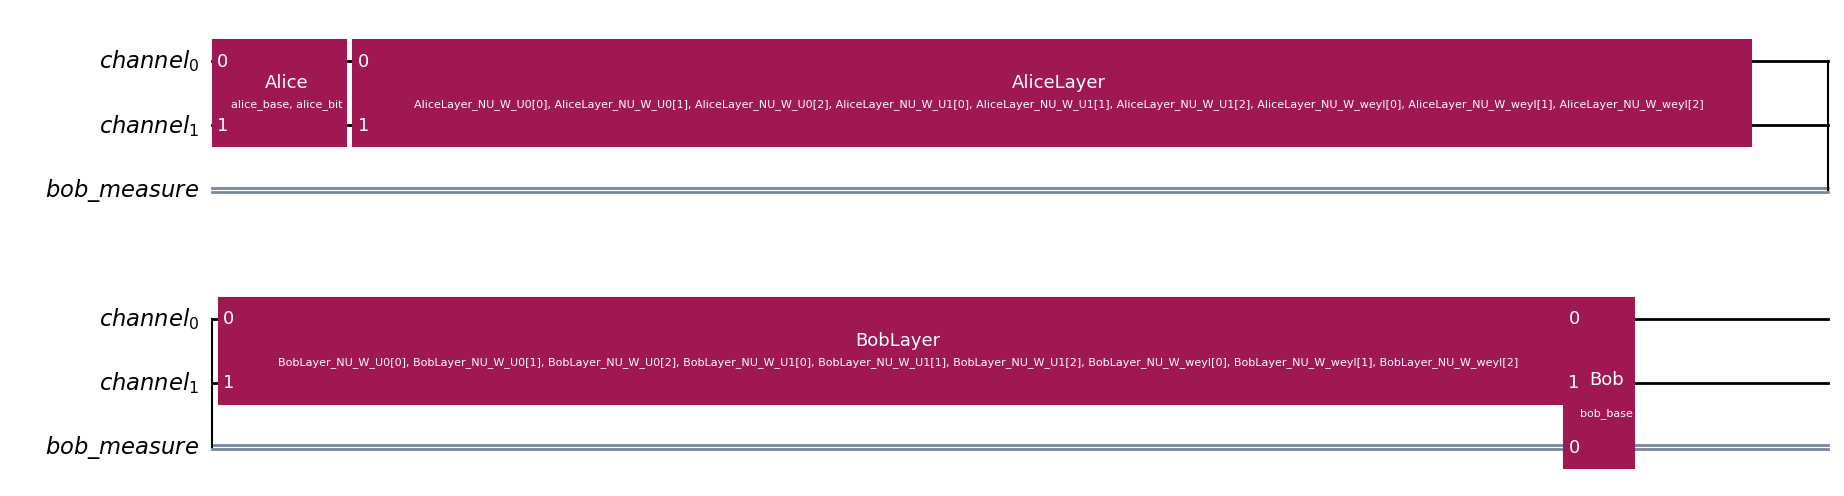

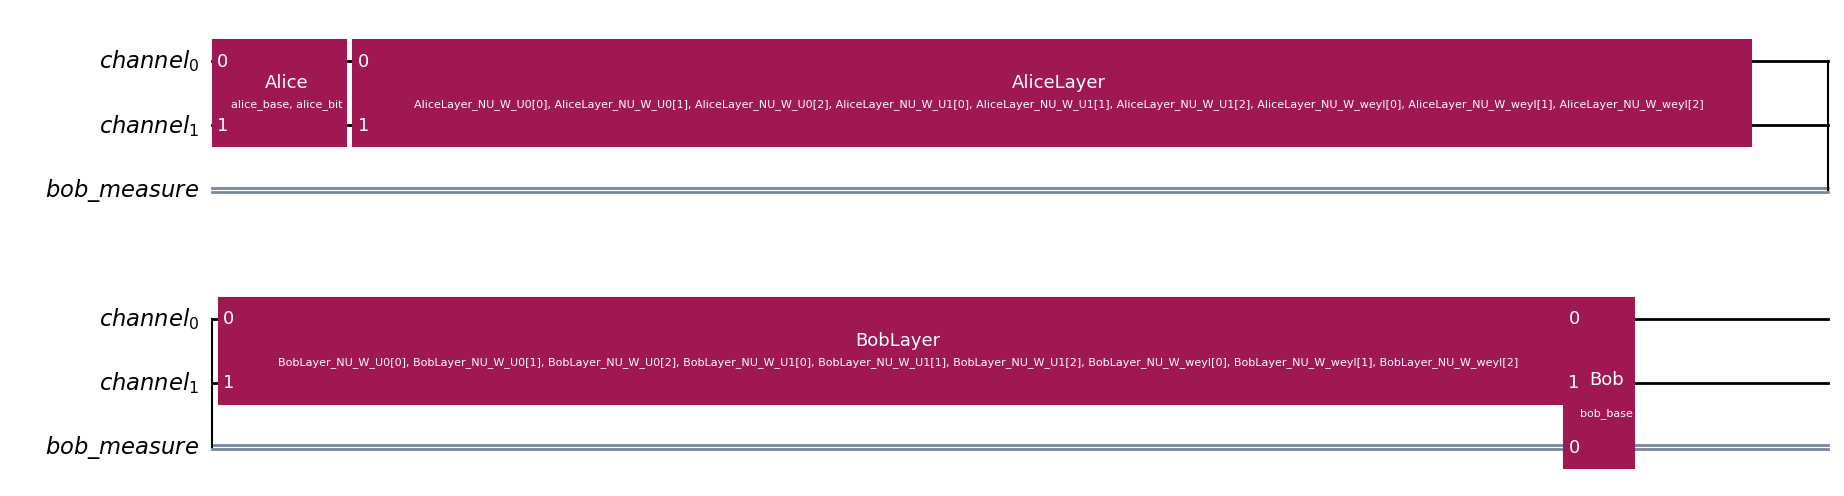

In [21]:
layers = [EntangledLayer("AliceLayer"), EntangledLayer("BobLayer")]
eve = MultiQubitQCLEve()

ab_protocol = BB84TrainableProtocol(n_bits=512, elements=layers, channel_size=2, seed=0, learning_rate=0.1)
eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=[layers[0], eve, layers[1]], channel_size=2,
                                        seed=0, alpha=1, learning_rate=0.05)

qc, _ = ab_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [22]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0 or epoch == 49:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

def train_ab():
    bob_qber, eve_qber = [], []
    qber = ab_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(0.5)
    print(f'start QBER: {qber}')
    for epoch in range(20):
        loss = ab_protocol.train()
        qber = ab_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(0.5)
        if epoch % 5 == 0 or epoch == 19:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

# Krok 1 - trenowanie Alice i Boba do początkowego stanu
Uczymy Alice i Boba bez Eve, aby miały sensowne parametry początkowe i potrafiły przekazywać sobie dane.

In [23]:
b_q, e_q = train_ab()

start QBER: {'bob_qber': np.float64(0.23015873015873012)}
epoch: 0, loss: -0.8016013503074646, QBER: {'bob_qber': np.float64(0.17460317460317465)}
epoch: 5, loss: -0.967958927154541, QBER: {'bob_qber': np.float64(0.019841269841269882)}
epoch: 10, loss: -0.9830265641212463, QBER: {'bob_qber': np.float64(0.007936507936507908)}
epoch: 15, loss: -0.9970368146896362, QBER: {'bob_qber': np.float64(0.003968253968253954)}
epoch: 19, loss: -0.9939630627632141, QBER: {'bob_qber': np.float64(0.0)}


<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

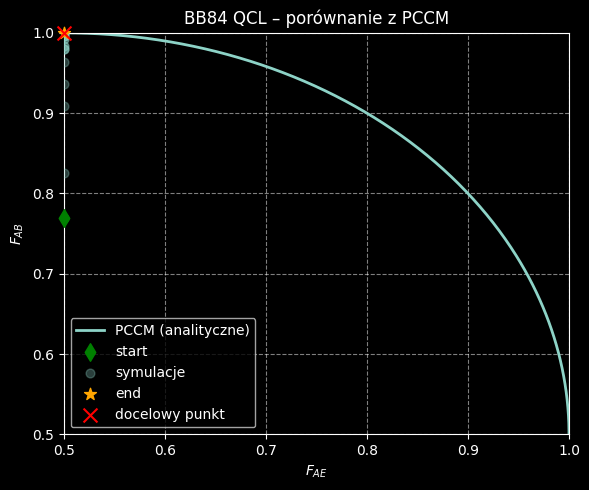

In [24]:
plt_fab_fae(b_q, e_q, 1)

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8. Startujemy od parametrów Alice i Boba wytrenowanych w poprzednim kroku i Eve jako identyczność.

In [25]:
eve_protocol.set_parameters(ab_protocol.get_all_parameters())

params = eve_protocol.get_all_parameters()
for p in eve.trainable_parameters():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'NU_W_0_0_U0[0]': np.float32(0.0), 'NU_W_0_0_U0[1]': np.float32(0.0), 'NU_W_0_0_U0[2]': np.float32(0.0), 'NU_W_0_0_U1[0]': np.float32(0.0), 'NU_W_0_0_U1[1]': np.float32(0.0), 'NU_W_0_0_U1[2]': np.float32(0.0), 'NU_W_0_0_weyl[0]': np.float32(0.0), 'NU_W_0_0_weyl[1]': np.float32(0.0), 'NU_W_0_0_weyl[2]': np.float32(0.0), 'NU_W_0_1_U0[0]': np.float32(0.0), 'NU_W_0_1_U0[1]': np.float32(0.0), 'NU_W_0_1_U0[2]': np.float32(0.0), 'NU_W_0_1_U1[0]': np.float32(0.0), 'NU_W_0_1_U1[1]': np.float32(0.0), 'NU_W_0_1_U1[2]': np.float32(0.0), 'NU_W_0_1_weyl[0]': np.float32(0.0), 'NU_W_0_1_weyl[1]': np.float32(0.0), 'NU_W_0_1_weyl[2]': np.float32(0.0), 'NU_W_1_0_U0[0]': np.float32(0.0), 'NU_W_1_0_U0[1]': np.float32(0.0), 'NU_W_1_0_U0[2]': np.float32(0.0), 'NU_W_1_0_U1[0]': np.float32(0.0), 'NU_W_1_0_U1[1]': np.float32(0.0), 'NU_W_1_0_U1[2]': np.float32(0.0), 'NU_W_1_0_weyl[0]': np.float32(0.0), 'NU_W_1_0_weyl[1]': np.float32(0.0), 'NU_W_1_0_weyl[2]': np.float32(0.0), 'NU_W_2_0_U0[0

In [26]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.011029411764705843), 'eve_qber': np.float64(0.5294117647058824)}
epoch: 0, loss: -0.9799721837043762, QBER: {'bob_qber': np.float64(0.003676470588235281), 'eve_qber': np.float64(0.5294117647058824)}
epoch: 5, loss: -0.9988938570022583, QBER: {'bob_qber': np.float64(0.0), 'eve_qber': np.float64(0.5330882352941176)}
epoch: 10, loss: -0.9873707294464111, QBER: {'bob_qber': np.float64(0.0), 'eve_qber': np.float64(0.5330882352941176)}
epoch: 15, loss: -1.0114389657974243, QBER: {'bob_qber': np.float64(0.0), 'eve_qber': np.float64(0.5220588235294117)}
epoch: 20, loss: -1.0051873922348022, QBER: {'bob_qber': np.float64(0.0), 'eve_qber': np.float64(0.46691176470588236)}
epoch: 25, loss: -1.0521667003631592, QBER: {'bob_qber': np.float64(0.018382352941176516), 'eve_qber': np.float64(0.3933823529411765)}
epoch: 30, loss: -1.1045212745666504, QBER: {'bob_qber': np.float64(0.07352941176470584), 'eve_qber': np.float64(0.27941176470588236)}
epoch: 35, loss: -1.1

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

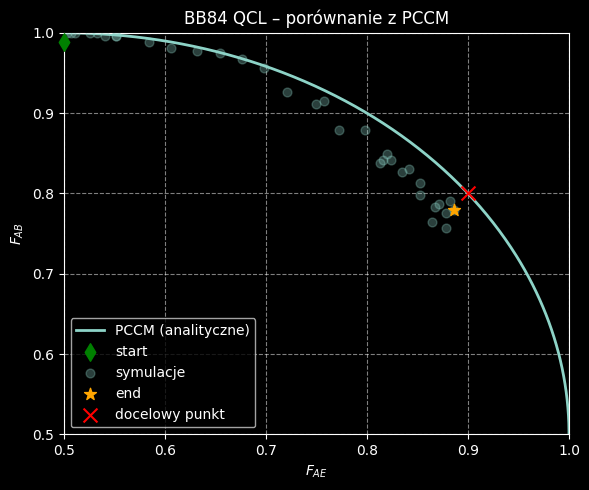

In [27]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [28]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'AliceLayer_NU_W_U0[0]': np.float32(0.105990745), 'AliceLayer_NU_W_U0[1]': np.float32(-0.16875316), 'AliceLayer_NU_W_U0[2]': np.float32(0.63152736), 'AliceLayer_NU_W_U1[0]': np.float32(1.3519796), 'AliceLayer_NU_W_U1[1]': np.float32(-0.49216926), 'AliceLayer_NU_W_U1[2]': np.float32(-0.90966344), 'AliceLayer_NU_W_weyl[0]': np.float32(-0.1491436), 'AliceLayer_NU_W_weyl[1]': np.float32(-0.027118511), 'AliceLayer_NU_W_weyl[2]': np.float32(0.07844871), 'BobLayer_NU_W_U0[0]': np.float32(-0.08016375), 'BobLayer_NU_W_U0[1]': np.float32(0.28973472), 'BobLayer_NU_W_U0[2]': np.float32(-0.7204248), 'BobLayer_NU_W_U1[0]': np.float32(-0.76015985), 'BobLayer_NU_W_U1[1]': np.float32(0.14025357), 'BobLayer_NU_W_U1[2]': np.float32(1.1372771), 'BobLayer_NU_W_weyl[0]': np.float32(0.00871386), 'BobLayer_NU_W_weyl[1]': np.float32(-0.11907065), 'BobLayer_NU_W_weyl[2]': np.float32(-0.03586763)}
Frozen parameters: {'NU_W_0_0_U0[0]': np.float32(-0.11541652), 'NU_W_0_0_U0[1]': np.float32(-

/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [29]:
eve_loss = eve_protocol.loss
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.22058823529411764), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 0, loss: -0.7986398935317993, QBER: {'bob_qber': np.float64(0.20588235294117652), 'eve_qber': np.float64(0.125)}
epoch: 5, loss: -0.8731220960617065, QBER: {'bob_qber': np.float64(0.12867647058823528), 'eve_qber': np.float64(0.19852941176470584)}
epoch: 10, loss: -0.9172049164772034, QBER: {'bob_qber': np.float64(0.0845588235294118), 'eve_qber': np.float64(0.27941176470588236)}
epoch: 15, loss: -0.9380214214324951, QBER: {'bob_qber': np.float64(0.047794117647058876), 'eve_qber': np.float64(0.36397058823529416)}
epoch: 20, loss: -0.9451600313186646, QBER: {'bob_qber': np.float64(0.05514705882352944), 'eve_qber': np.float64(0.38602941176470584)}
epoch: 25, loss: -0.9482696056365967, QBER: {'bob_qber': np.float64(0.06985294117647056), 'eve_qber': np.float64(0.4007352941176471)}
epoch: 30, loss: -0.9461754560470581, QBER: {'bob_qber': np.float64(0.044117647058823484), 'eve_qber': n

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

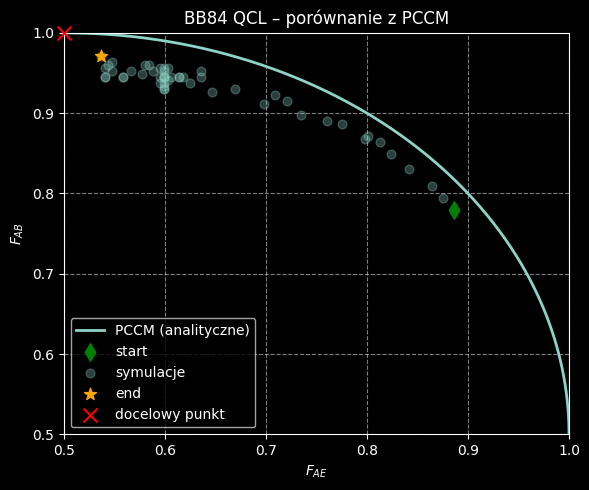

In [30]:
plt_fab_fae(b_q, e_q, 1)

In [31]:
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'NU_W_0_0_U0[0]': np.float32(-0.11541652), 'NU_W_0_0_U0[1]': np.float32(-0.18439473), 'NU_W_0_0_U0[2]': np.float32(-0.15996715), 'NU_W_0_0_U1[0]': np.float32(0.50547755), 'NU_W_0_0_U1[1]': np.float32(-0.14615624), 'NU_W_0_0_U1[2]': np.float32(-0.90451616), 'NU_W_0_0_weyl[0]': np.float32(0.967408), 'NU_W_0_0_weyl[1]': np.float32(0.5591662), 'NU_W_0_0_weyl[2]': np.float32(0.84564793), 'NU_W_0_1_U0[0]': np.float32(0.72793466), 'NU_W_0_1_U0[1]': np.float32(-0.39030135), 'NU_W_0_1_U0[2]': np.float32(2.4279019e-09), 'NU_W_0_1_U1[0]': np.float32(-0.12636225), 'NU_W_0_1_U1[1]': np.float32(0.30333203), 'NU_W_0_1_U1[2]': np.float32(1.8121231e-09), 'NU_W_0_1_weyl[0]': np.float32(-0.020567013), 'NU_W_0_1_weyl[1]': np.float32(-0.012057024), 'NU_W_0_1_weyl[2]': np.float32(-0.40195125), 'NU_W_1_0_U0[0]': np.float32(0.049102064), 'NU_W_1_0_U0[1]': np.float32(-0.09726374), 'NU_W_1_0_U0[2]': np.float32(-0.068287216), 'NU_W_1_0_U1[0]': np.float32(0.47051412), 'NU_W_1_0_U1[1]': np.f

/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [32]:
eve_protocol.f_value = 0.8
eve_protocol.loss = eve_loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.02941176470588236), 'eve_qber': np.float64(0.4632352941176471)}
epoch: 0, loss: -0.9744932651519775, QBER: {'bob_qber': np.float64(0.018382352941176516), 'eve_qber': np.float64(0.43014705882352944)}
epoch: 5, loss: -1.079477071762085, QBER: {'bob_qber': np.float64(0.047794117647058876), 'eve_qber': np.float64(0.2977941176470589)}
epoch: 10, loss: -1.173291563987732, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.15441176470588236)}
epoch: 15, loss: -1.194877028465271, QBER: {'bob_qber': np.float64(0.24264705882352944), 'eve_qber': np.float64(0.10661764705882348)}
epoch: 20, loss: -1.1779959201812744, QBER: {'bob_qber': np.float64(0.2977941176470589), 'eve_qber': np.float64(0.06985294117647056)}
epoch: 25, loss: -1.1927129030227661, QBER: {'bob_qber': np.float64(0.28308823529411764), 'eve_qber': np.float64(0.06985294117647056)}
epoch: 30, loss: -1.2032322883605957, QBER: {'bob_qber': np.float64(0.24264705882352944), 'ev

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

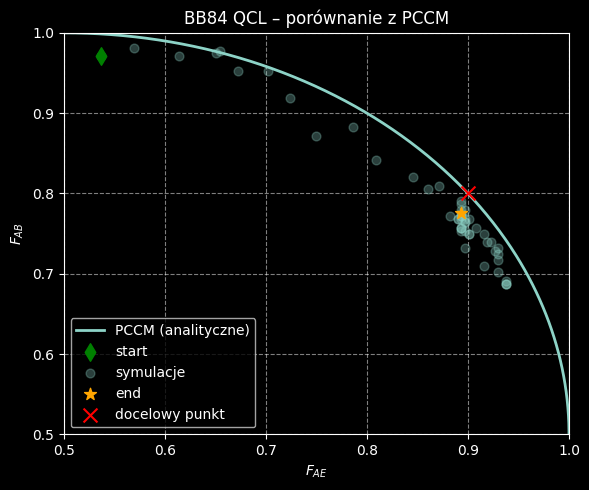

In [33]:
plt_fab_fae(b_q, e_q, 0.8)

In [34]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'AliceLayer_NU_W_U0[0]': np.float32(-0.1877965), 'AliceLayer_NU_W_U0[1]': np.float32(-0.45665208), 'AliceLayer_NU_W_U0[2]': np.float32(0.25185397), 'AliceLayer_NU_W_U1[0]': np.float32(1.2302457), 'AliceLayer_NU_W_U1[1]': np.float32(-1.938202), 'AliceLayer_NU_W_U1[2]': np.float32(-0.90966344), 'AliceLayer_NU_W_weyl[0]': np.float32(-0.66164005), 'AliceLayer_NU_W_weyl[1]': np.float32(-0.96091276), 'AliceLayer_NU_W_weyl[2]': np.float32(-0.7139517), 'BobLayer_NU_W_U0[0]': np.float32(-0.7043968), 'BobLayer_NU_W_U0[1]': np.float32(0.75568473), 'BobLayer_NU_W_U0[2]': np.float32(-0.28228268), 'BobLayer_NU_W_U1[0]': np.float32(-0.3244447), 'BobLayer_NU_W_U1[1]': np.float32(0.36048865), 'BobLayer_NU_W_U1[2]': np.float32(1.7349601), 'BobLayer_NU_W_weyl[0]': np.float32(0.46080428), 'BobLayer_NU_W_weyl[1]': np.float32(-0.104020074), 'BobLayer_NU_W_weyl[2]': np.float32(-0.0073872646)}
Frozen parameters: {'NU_W_0_0_U0[0]': np.float32(-0.36278984), 'NU_W_0_0_U0[1]': np.float32(0.

/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [35]:
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.22426470588235292), 'eve_qber': np.float64(0.10661764705882348)}
epoch: 0, loss: -0.8088144659996033, QBER: {'bob_qber': np.float64(0.23529411764705888), 'eve_qber': np.float64(0.11764705882352944)}
epoch: 5, loss: -0.8590127825737, QBER: {'bob_qber': np.float64(0.15073529411764708), 'eve_qber': np.float64(0.18382352941176472)}
epoch: 10, loss: -0.90274977684021, QBER: {'bob_qber': np.float64(0.1029411764705882), 'eve_qber': np.float64(0.28308823529411764)}
epoch: 15, loss: -0.9095301032066345, QBER: {'bob_qber': np.float64(0.09191176470588236), 'eve_qber': np.float64(0.40441176470588236)}
epoch: 20, loss: -0.9208372831344604, QBER: {'bob_qber': np.float64(0.07720588235294112), 'eve_qber': np.float64(0.4816176470588235)}
epoch: 25, loss: -0.9412155151367188, QBER: {'bob_qber': np.float64(0.05514705882352944), 'eve_qber': np.float64(0.5036764705882353)}
epoch: 30, loss: -0.9685675501823425, QBER: {'bob_qber': np.float64(0.05882352941176472), 'eve_qb

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

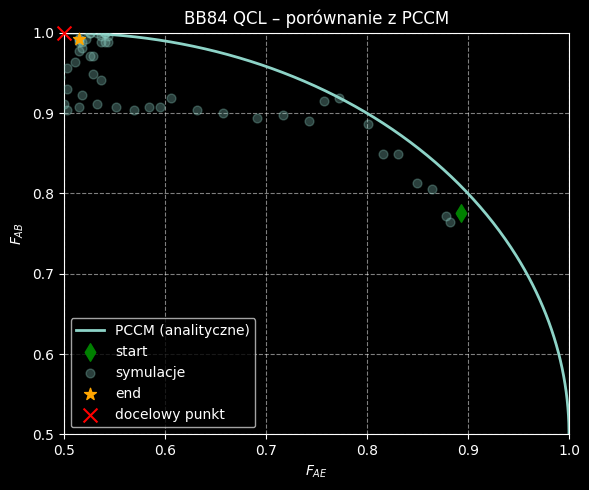

In [36]:
plt_fab_fae(b_q, e_q, 1)

In [37]:
print("All parameters:", eve_protocol.get_all_parameters())

All parameters: {'NU_W_0_0_U0[0]': np.float32(-0.36278984), 'NU_W_0_0_U0[1]': np.float32(0.35069796), 'NU_W_0_0_U0[2]': np.float32(0.27843285), 'NU_W_0_0_U1[0]': np.float32(1.0279669), 'NU_W_0_0_U1[1]': np.float32(-0.5163962), 'NU_W_0_0_U1[2]': np.float32(-0.5059375), 'NU_W_0_0_weyl[0]': np.float32(0.9807007), 'NU_W_0_0_weyl[1]': np.float32(1.0431337), 'NU_W_0_0_weyl[2]': np.float32(0.7779182), 'NU_W_0_1_U0[0]': np.float32(0.9675189), 'NU_W_0_1_U0[1]': np.float32(-0.4670279), 'NU_W_0_1_U0[2]': np.float32(2.4279019e-09), 'NU_W_0_1_U1[0]': np.float32(-0.038741805), 'NU_W_0_1_U1[1]': np.float32(0.9512137), 'NU_W_0_1_U1[2]': np.float32(-1.99349e-09), 'NU_W_0_1_weyl[0]': np.float32(-0.019185869), 'NU_W_0_1_weyl[1]': np.float32(0.006766543), 'NU_W_0_1_weyl[2]': np.float32(-0.45998082), 'NU_W_1_0_U0[0]': np.float32(0.38765946), 'NU_W_1_0_U0[1]': np.float32(0.22361976), 'NU_W_1_0_U0[2]': np.float32(0.06746475), 'NU_W_1_0_U1[0]': np.float32(0.363606), 'NU_W_1_0_U1[1]': np.float32(-0.53085977), 

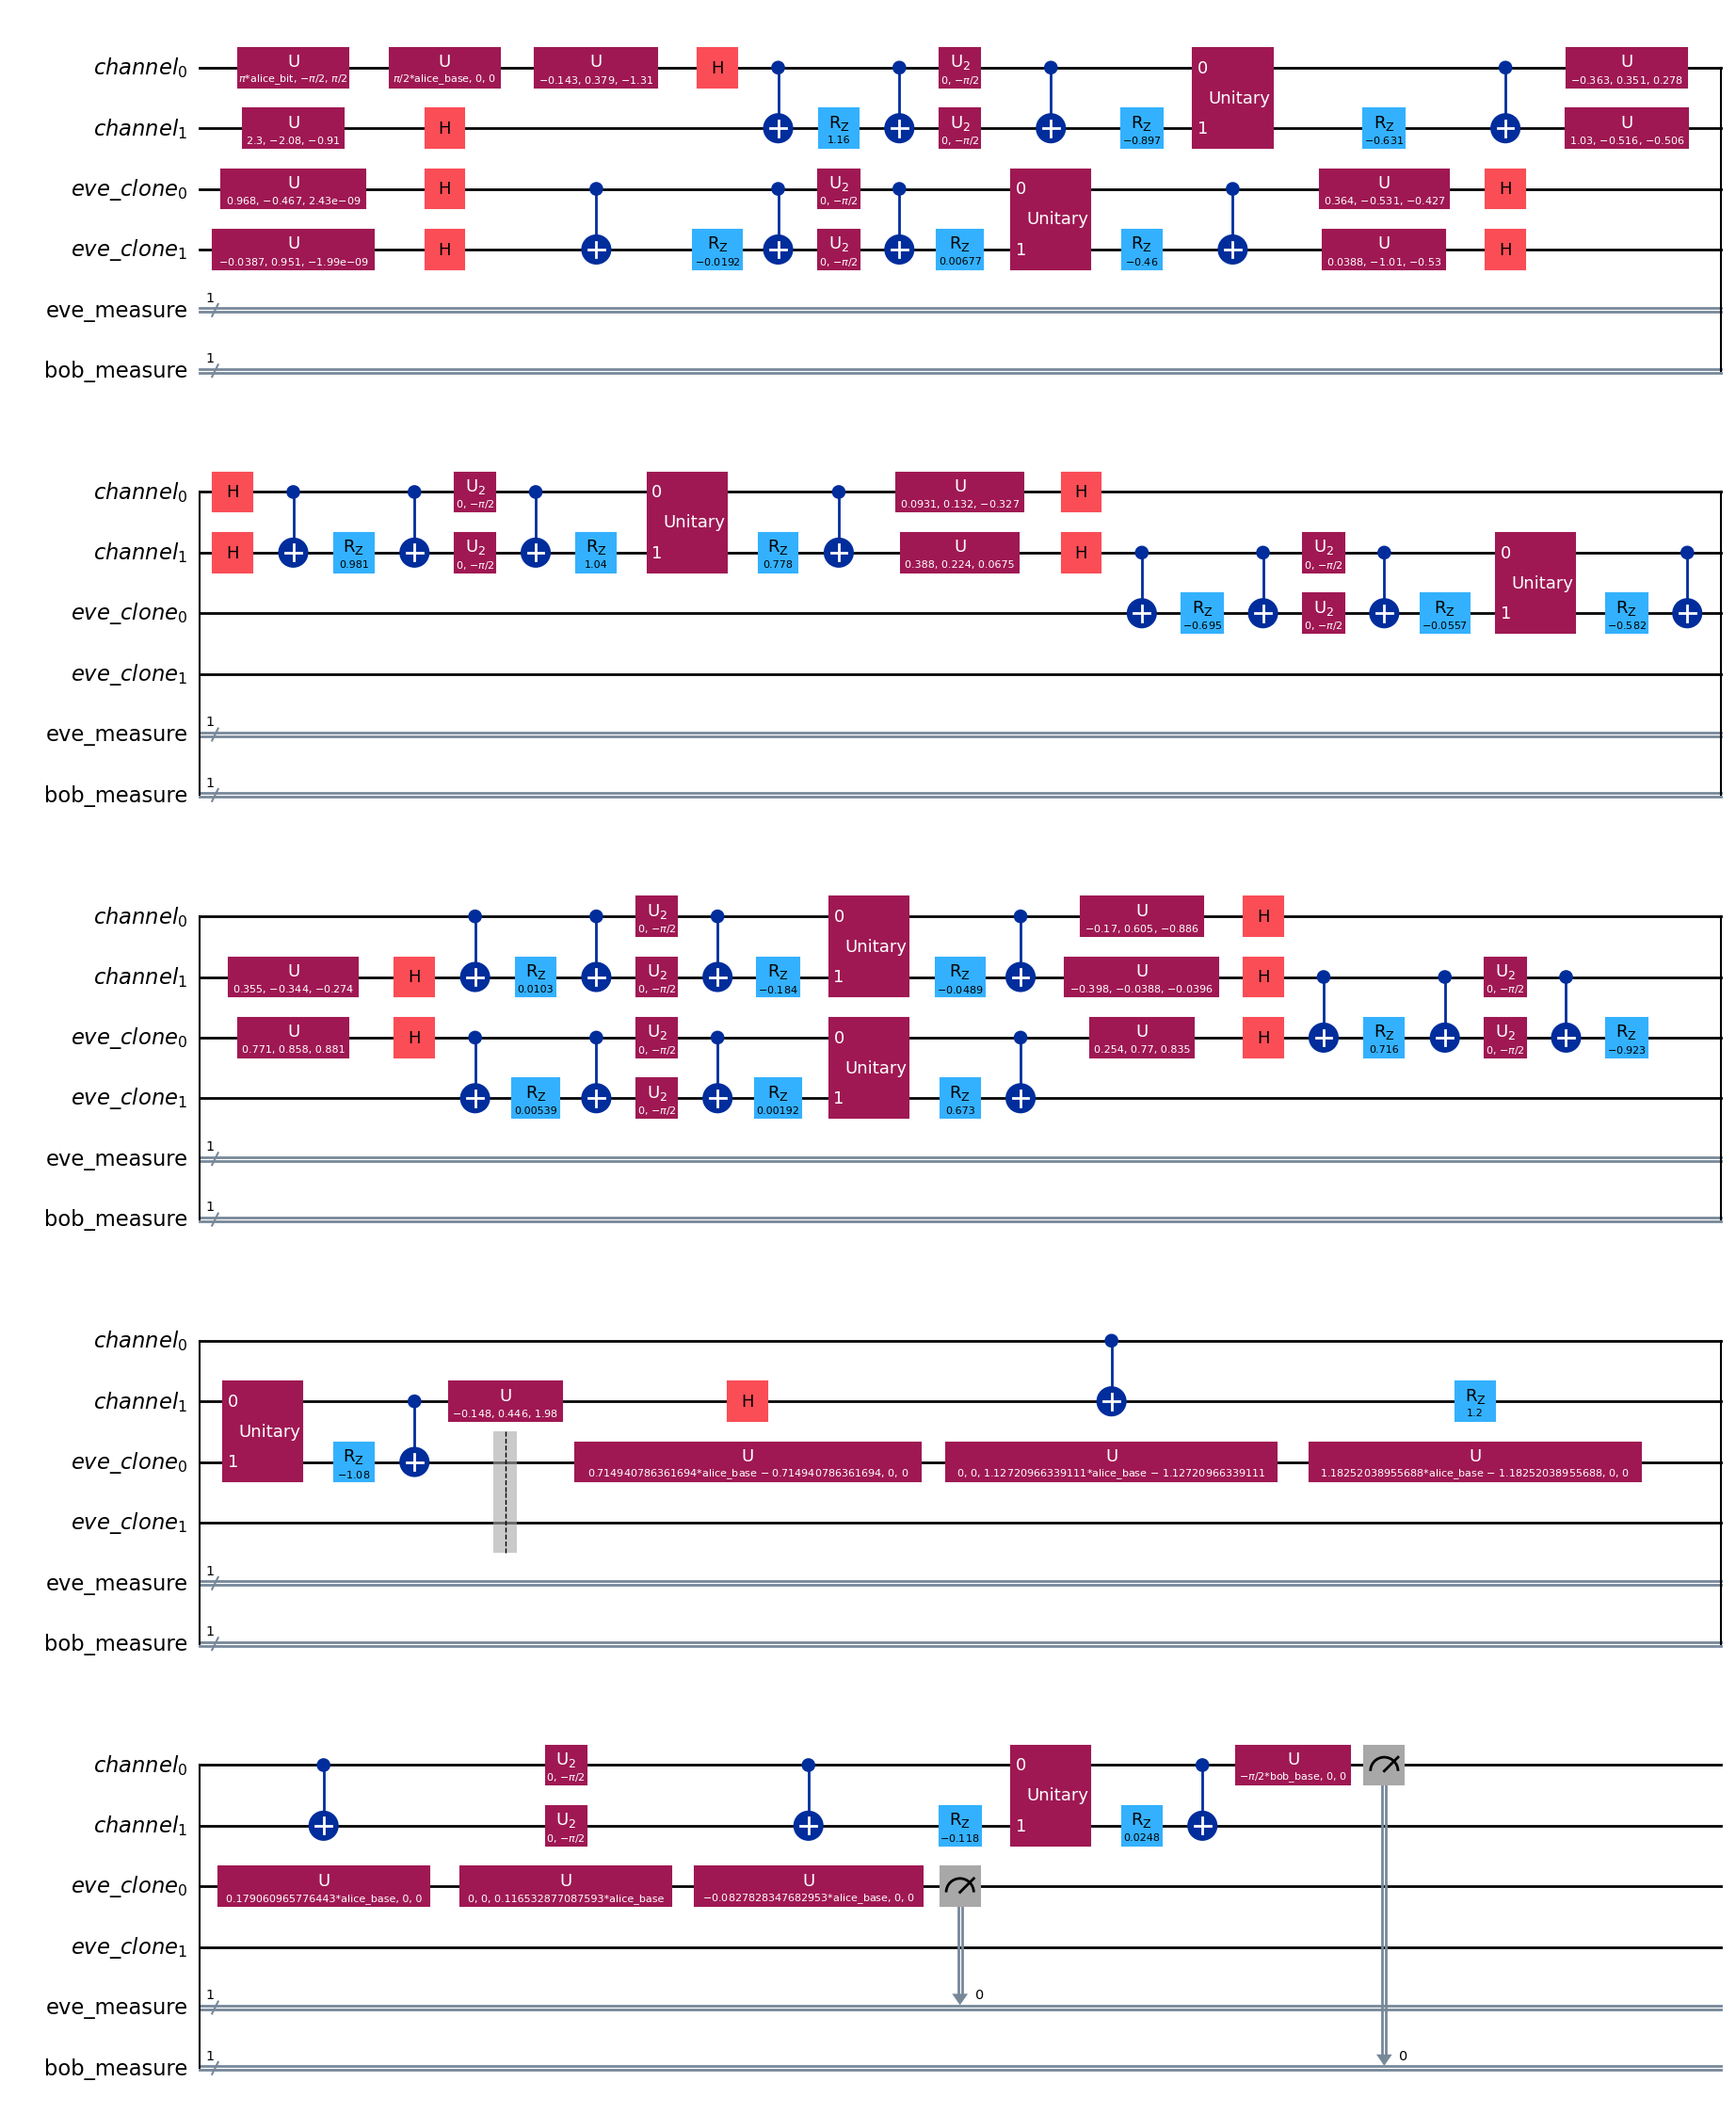

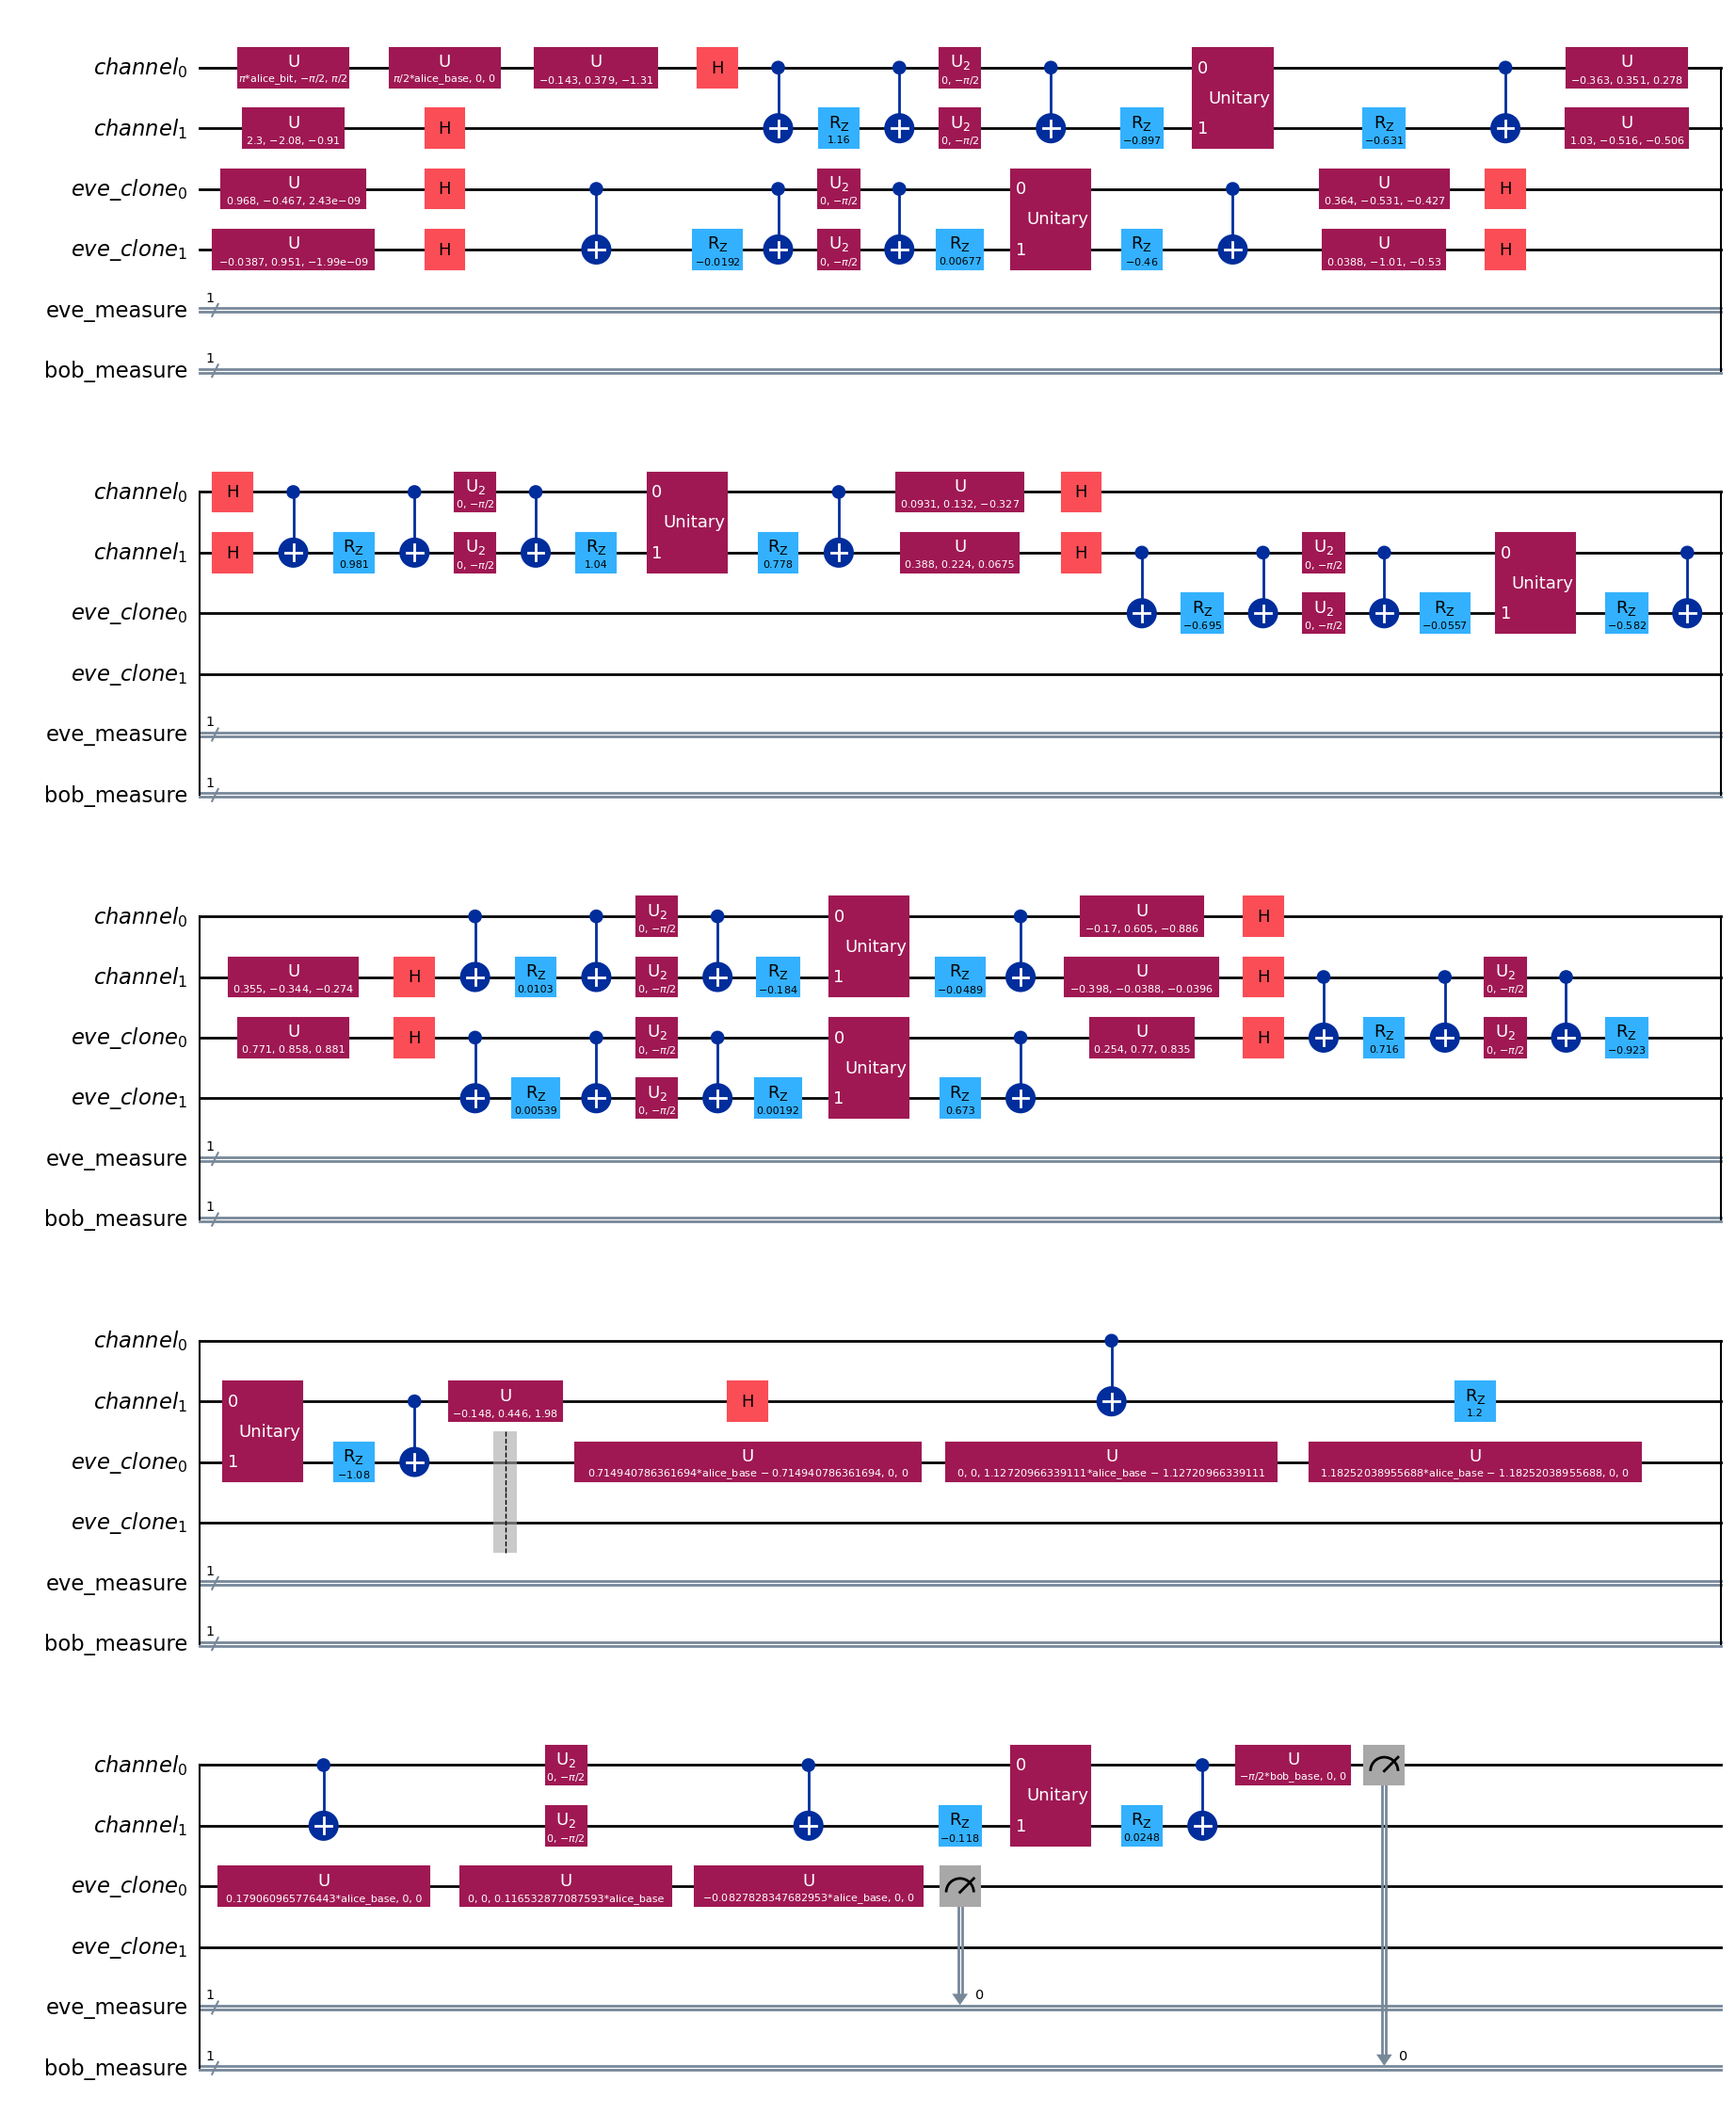

In [38]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")